In [1]:
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['image.cmap'] = 'gray'
plt.rcParams['axes.grid'] = False

from keras.datasets import mnist
from sklearn.neural_network import BernoulliRBM

Using TensorFlow backend.
D:\ProgrammaX100\Anaconda\envs\tensorflow\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
D:\ProgrammaX100\Anaconda\envs\tensorflow\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
D:\ProgrammaX100\Anaconda\envs\tensorflow\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
D:\ProgrammaX100\Anaconda\env

## Utility functions used in the notebook

In [3]:
def rbm_gibbs_sample_image(rbm, im, steps):
  assert len(im.shape) < 3
  if len(im.shape) == 2:
    rows = im.shape[0]
    cols = im.shape[1]
    im = im.reshape((-1))
  else:
    im = im.copy()
  for _ in range(steps):
    im = rbm.gibbs(im)
  if rows is not None and cols is not None:
    im = im.reshape((rows, cols))
  return im.astype('float32')
    
def image_palette(X, nr = 0, m = 20):
  if nr is 0:
    nr = X.shape[0]
  return np.rollaxis(np.rollaxis(X[0:nr].reshape(m, -1, 28, 28), 0, 2), 1, 3).reshape(-1, m * 28)

def remove_rows(X, start, end):
  X = X.copy()
  if len(X.shape) == 2:
    X[start:end] = 0
  elif len(X.shape) == 3:
    X[:,start:end] = 0
  return X

## Load and show the mnist data

In [4]:
(X_train, Y_train), (X_test, Y_test) = mnist.load_data()
X_train = X_train.reshape((X_train.shape[0], -1))
X_test = X_test.reshape((X_test.shape[0],-1))
X_train = X_train.astype('float32') / 255
X_test = X_test.astype('float32') / 255
X_test = X_test[0:100]

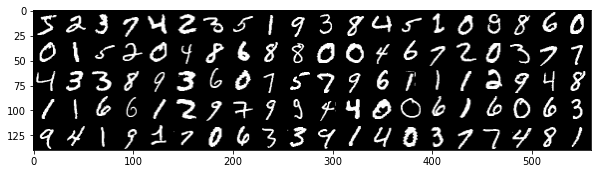

In [50]:
flattened_images = image_palette(X_train, 100,20)
plt.figure(figsize=(10,20))
plt.imshow(flattened_images)

In [48]:
flattened_images.shape

(140, 560)

## Train the RBM
**Exercise** What is the effect of the different parameters: **n_components**, **learning_rate**, **n_iter**. These parameters are, respectively, the number of components, the learning rate and the number of iterations. <br/>
Evaluate the performance visually in the next code cell.

the number of compenents equals the number of hidden units.


In [62]:
# unsupervised learning
rbm = BernoulliRBM(n_components=20, learning_rate=0.01, random_state=0, n_iter=20, verbose=True)
rbm.fit(X_train)

[BernoulliRBM] Iteration 1, pseudo-likelihood = -198.55, time = 4.44s
[BernoulliRBM] Iteration 2, pseudo-likelihood = -190.71, time = 3.95s
[BernoulliRBM] Iteration 3, pseudo-likelihood = -183.24, time = 3.76s
[BernoulliRBM] Iteration 4, pseudo-likelihood = -171.83, time = 4.08s
[BernoulliRBM] Iteration 5, pseudo-likelihood = -167.43, time = 3.80s
[BernoulliRBM] Iteration 6, pseudo-likelihood = -164.57, time = 4.66s
[BernoulliRBM] Iteration 7, pseudo-likelihood = -160.62, time = 4.00s
[BernoulliRBM] Iteration 8, pseudo-likelihood = -155.76, time = 3.64s
[BernoulliRBM] Iteration 9, pseudo-likelihood = -151.76, time = 3.67s
[BernoulliRBM] Iteration 10, pseudo-likelihood = -148.69, time = 3.71s
[BernoulliRBM] Iteration 11, pseudo-likelihood = -146.28, time = 4.05s
[BernoulliRBM] Iteration 12, pseudo-likelihood = -145.28, time = 5.30s
[BernoulliRBM] Iteration 13, pseudo-likelihood = -144.72, time = 3.87s
[BernoulliRBM] Iteration 14, pseudo-likelihood = -143.24, time = 3.83s
[BernoulliRBM] 

BernoulliRBM(learning_rate=0.01, n_components=20, n_iter=20, random_state=0,
             verbose=True)

## Sample the trained RBM and show the result
The gibbs_steps variable determines how many Gibbs sampling steps will be performed for each test image i.e. with the test images as initialization. <br/>
**Exercise** Try different values and observe the result. Can you explain the result? <br/>
Compare the result with the original test images, shown one cell lower.

- more gibbs samples done --> original is less easy to recognize --> differs more from test image

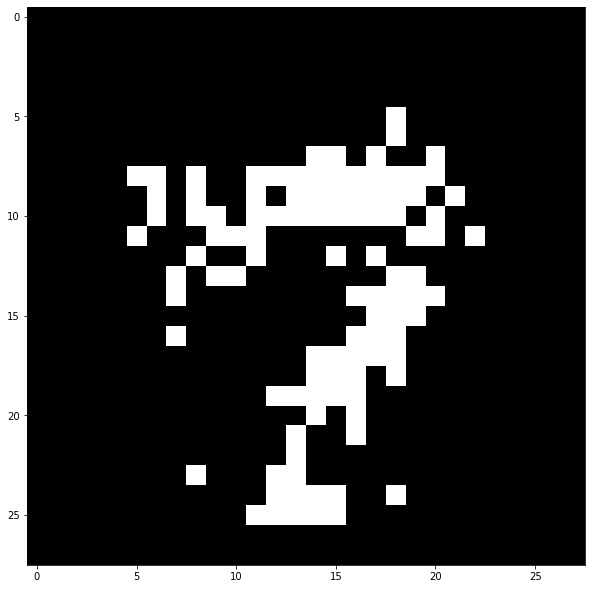

In [60]:
gibbs_steps = 10
a = X_test.copy()
for i in range(a.shape[0]):
  for j in range(gibbs_steps):
    a[i] = rbm.gibbs(a[i])
plt.figure(figsize=(10,20))
plt.imshow(image_palette(a,1,1))

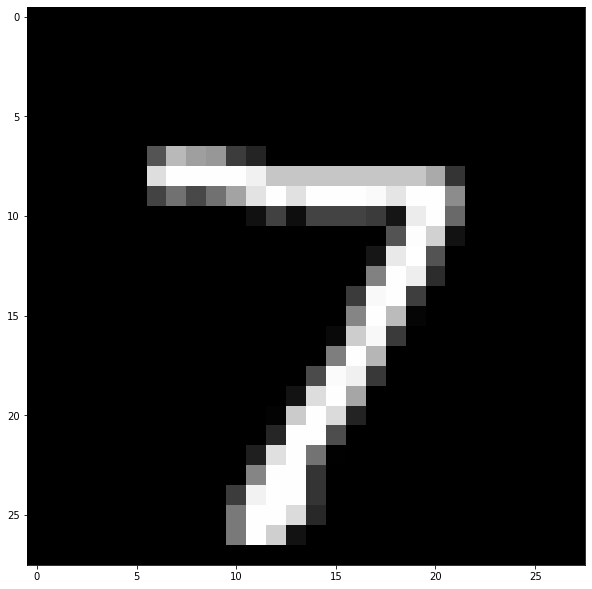

In [61]:
plt.figure(figsize=(10,20))
plt.imshow(image_palette(X_test,1,1))

## Reconstruction of unseen images
In this cell, we will remove pixel rows from certain images. Using the recently trained RBM, we will then try to reconstruct the original images.  <br/>
The following variables control this process: <br/>


*   **reconstruction_gibbs_steps**: The number of gibbs steps used to reconstruct the image.
*   **start_test_index**: The first index of the test set to use.
*   **nr**: the number of images starting from **start_test_index** to reconstruct.
*   **start_row_to_remove**:  The index of the first row that should be removed.
*   **end_row_to_remove**: The index up to which the rows should be removed.

**Exercise** Adjust these variables and observe the result of the reconstruction in the shown image.
What is the role of the previously seen RBM hyperparameters on the reconstruction? <br/>
How many rows can you remove such that reconstruction is still possible? <br/>
In the next code cell, the removed rows will be replaced by the reconstructed rows.

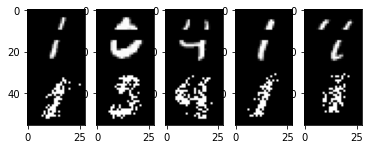

In [67]:
reconstruction_gibbs_steps = 10
start_test_index = 2
nr = 5
start_row_to_remove = 10
end_row_to_remove = 15
to_reconstruct = X_test[start_test_index:start_test_index + nr].reshape((-1,28,28))
to_reconstruct = remove_rows(to_reconstruct, start_row_to_remove, end_row_to_remove)
reconstructed = np.zeros(to_reconstruct.shape)
for i in range(nr):
  reconstructed[i] = rbm_gibbs_sample_image(rbm, to_reconstruct[i], reconstruction_gibbs_steps)
combined_images = np.concatenate((to_reconstruct,reconstructed), axis=1)
fig = plt.figure()
for i in range(nr): 
  ax1 = fig.add_subplot(1,nr,i+1)
  ax1.imshow(combined_images[i])
plt.savefig("D:\Burgie_taken\ANN\EX4\\reconstruction.png", dpi=300, facecolor='w', edgecolor='w', orientation='portrait', format=None,
                    transparent=False, bbox_inches='tight', pad_inches=0.1, metadata=None)
plt.show()

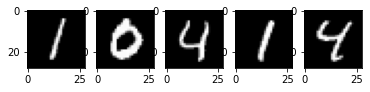

In [36]:
start_row_to_remove
end_row_to_remove
to_reconstruct[:,start_row_to_remove:end_row_to_remove] = reconstructed[:,start_row_to_remove:end_row_to_remove]
fig = plt.figure()
for i in range(nr): 
  ax1 = fig.add_subplot(1,nr,i+1)
  ax1.imshow(to_reconstruct[i])

plt.show()

## Component visualisation
In the final cell, the components (weights of each neuron) of the RBM are shown.<br/> 
Observing these components (think back to CNNs) may offer insights into the trained model.

C:\Users\Stijn\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:5: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  """


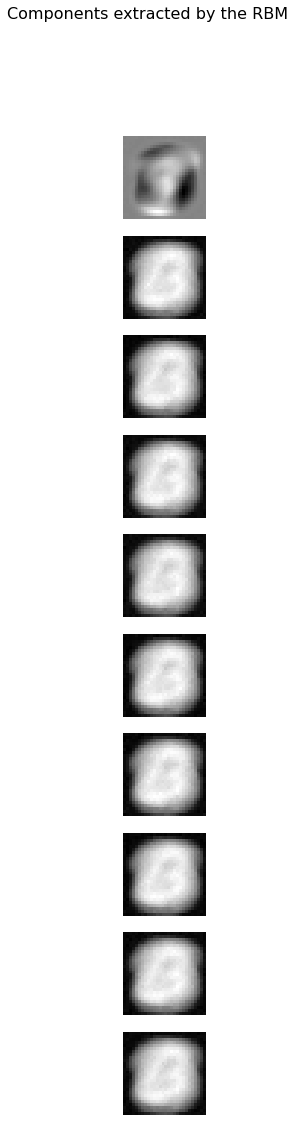

In [37]:
plt.figure(figsize=(18, 18))
nr_components = rbm.components_.shape[0]
for i in range(nr_components):
    c = rbm.components_[i]
    plt.subplot(10, np.ceil(nr_components/10), i + 1)
    plt.imshow(c.reshape((28, 28)), cmap = "gray", interpolation='nearest')
    plt.axis('off')

plt.suptitle('Components extracted by the RBM', fontsize=16);